# Exploring evaluation 

This dataset consists on some code for exploring the decisions of the trained model.

The idea is to use the predictions on the test set, as well as some of the properties of those measures, such as age weight and height, to spot if the model is performing bad in some segments of the population/measures.

This is a simple notebook, and this is idea can/should be further extended in production environments. Here, no conclusions are drawn, and just some plots are presented.

## Mount repository
Doing this to make sure we have all the files of the repository.
Here it is used to load the model. *torch.load* will make use of the model script in the repository.

In [1]:
!git clone https://[PERSONAL ACCESS TOKEN REMOVED HERE!!!]@github.com/sergi-andreu/Idoven-challenge.git idoven

Cloning into 'idoven'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 72 (delta 34), reused 52 (delta 17), pack-reused 0
Unpacking objects: 100% (72/72), done.


## Mount drive and import some required packages

In [2]:
# Mount drive to access the required files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import required packages
import pandas as pd
import numpy as np

import ast # to literal evaluate

# Plotting packages:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

## Importing csv files

Import the csv drives from drive (*ptbxl_database* and *scp_statements*)

In [4]:
Y = pd.read_csv("drive/MyDrive/idoven/ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv("drive/MyDrive/idoven/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [5]:
"""
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer(classes = ["NORM", "MI", "STTC", "CD", "HYP"])

# Get only validation data
new_Y = Y[(Y.strat_fold == 10)]
"""

'\nfrom sklearn.preprocessing import MultiLabelBinarizer\nenc = MultiLabelBinarizer(classes = ["NORM", "MI", "STTC", "CD", "HYP"])\n\n# Get only validation data\nnew_Y = Y[(Y.strat_fold == 10)]\n'

## Compute predictions for all models

### Load data

In [6]:
# Import pytorch 
import torch
from torch.utils.data import TensorDataset

import pickle as pkl # to load/save arbitrary python objects. Here used to load the scaler parameters
from sklearn.preprocessing import StandardScaler # to scale the test data with the scaler used for training

drivepath = "drive/MyDrive/idoven"

# Load the scalr
with open("drive/MyDrive/idoven/scalers/standardscaler.txt", "rb") as filehandle:
  dict_scaler = pkl.load(filehandle)

scaler = StandardScaler() # initialize scaler
# set scaler values:
scaler.mean_ = dict_scaler["mean_"]
scaler.var_ = dict_scaler["var_"]
scaler.scale_ = dict_scaler["scale_"]

# Set device (preferably cuda. Set the execution environment of colab to GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the apply scaler function
def apply_scaler(X, scaler):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(scaler.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

# Load test data and labels (fold 10; not used for training nor validation)
X_test = np.load(f"{drivepath}/nparrays/10.npy")
Y_test = np.load(f"{drivepath}/nparrays/labels/10.npy")

# scale the data using the scaler
X_test = apply_scaler(X_test, scaler)

# Create dataset. This is not really required in this problem setting, but doing it for better practices:
X_test, Y_test = torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float()
test_dataset = TensorDataset(X_test, Y_test)
del X_test, Y_test # delete variables (only saving the "dataset" variables)

In [7]:
# Create a dataloader to ease the batch-loading
from torch.utils.data import DataLoader, BatchSampler
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Shuffle can be either True/False here, since we always evaluate the whole set

### Load model
And also show a model summary. We also plot the model using torchviz. 
The image is saved in the *fig/* directory of the repository.

In [8]:
model_folder_path = "drive/MyDrive/idoven/models/"
model_code = "_lr_0.0005_epochs_5" # Model used. 
# It is "the best", according to the hyperparameter tuning (I only try different lr and epochs)
# All models gave similar results, and further hyperparameter tuning would be needed in production


# Load model
model = torch.load(model_folder_path + model_code).to(device)
model.eval() # Set to eval mode (for batchnorm mostly, if not, errors occur (of course))

ResNet(
  (conv1): Conv1d(12, 32, kernel_size=(15,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, tr

Plot the model using torchviz

In [9]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4149 sha256=3ae2ccfb820fa54a30fd188af30fe334a3fa8ba1ae8f538d57cb2dfae94cc104
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [11]:
from torchviz import make_dot

batch = next(iter(test_dataloader))
x_, y_ = batch
yhat = model(x_.to(device))

make_dot(yhat, params=dict(list(model.named_parameters()))).render("resnet_torchviz", format="png")

'resnet_torchviz.png'

### Compute predictions

In [12]:
y_preds = []
y_trues = []

for idx, (x, y) in enumerate(test_dataloader):
    y_trues.append(y.numpy())
    x = x.to(device)
    y_pred = model.forward(x)
    y_preds.append(y_pred.cpu().detach().numpy())

(y_preds, y_trues) = (np.concatenate(y_preds,axis=0), np.concatenate(y_trues,axis=0))
y_preds = np.squeeze(y_preds)
y_trues = np.squeeze(y_trues)

### Define the thresholds for each label, following the results from the evaluation notebook.

In [13]:
thresholds_list = [0.911365, 0.3409352, 0.26424393, -0.050233312, -0.9349181] #FROM THE EVALUATION NOTEBOOK

y_preds_discrete = np.copy(y_preds)
for idx in range(5):
  # Set to discrete predictions
  y_preds_discrete[y_preds[:,idx] >= thresholds_list[idx] , idx] = 1.0
  y_preds_discrete[y_preds[:,idx] < thresholds_list[idx]   , idx] = 0.0

### Plotting the confusion matrices
Compute the confusion matrix for each of the 5 labels

In [14]:
from sklearn.metrics import confusion_matrix

dict_names = {0 : "NORM", 1 : "MI", 2: "STTC", 3 : "CD", 4 : "HYP"}
cm_dict = {}

for key, val in dict_names.items():
  cm = confusion_matrix(y_trues[:,key], y_preds_discrete[:,key])
  cm_dict[val] = cm

Define a plotting function for the confusion matrix dictionary

In [15]:
def plot_cm_dict(cm_dict, normalize=False):

  fig, axs = plt.subplots(3,2, figsize=(5,7))
  for idx, (key, val) in enumerate(cm_dict.items()):

    cm = val
    row_idx = idx%3
    col_idx = idx//3
    ax = axs[row_idx, col_idx]

    if normalize: 
      cm = cm / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale=1.4)

    fmt="g" # Avoid scientific notation
    if normalize: fmt = ".2f" # If normalized version, only show two decimals
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=fmt, cbar=False, ax=ax)

    ax.set_title(key)

  axs[2,1].axis("off")

  fig.tight_layout()
  plt.show()

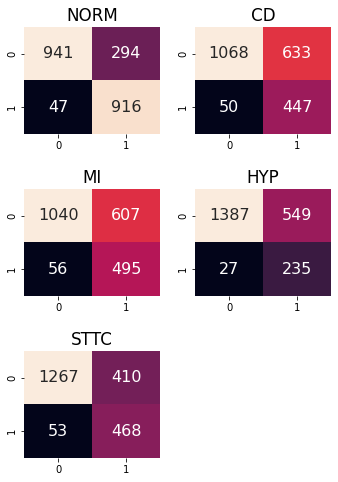

In [16]:
plot_cm_dict(cm_dict, normalize=False)

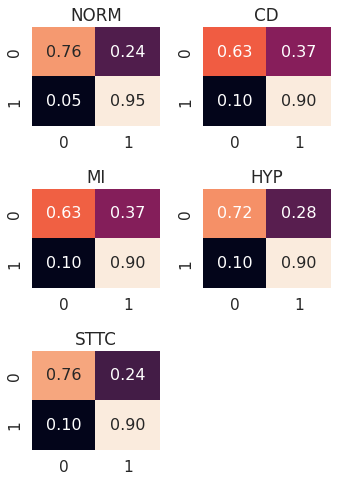

In [17]:
plot_cm_dict(cm_dict, normalize=True)

### Study the keys on incorrect labels

The idea here is to have some histplots on the key distributions (age, weight, height, ...) for true positives, false positives, ... for each label.

A better exploration on the evaluation could be done by also plotting features shown in the exploration notebook, etc.

However, this is only an example, and not production-level code.

Showing distribution of age, height and weight for the different predictions on the NORM label


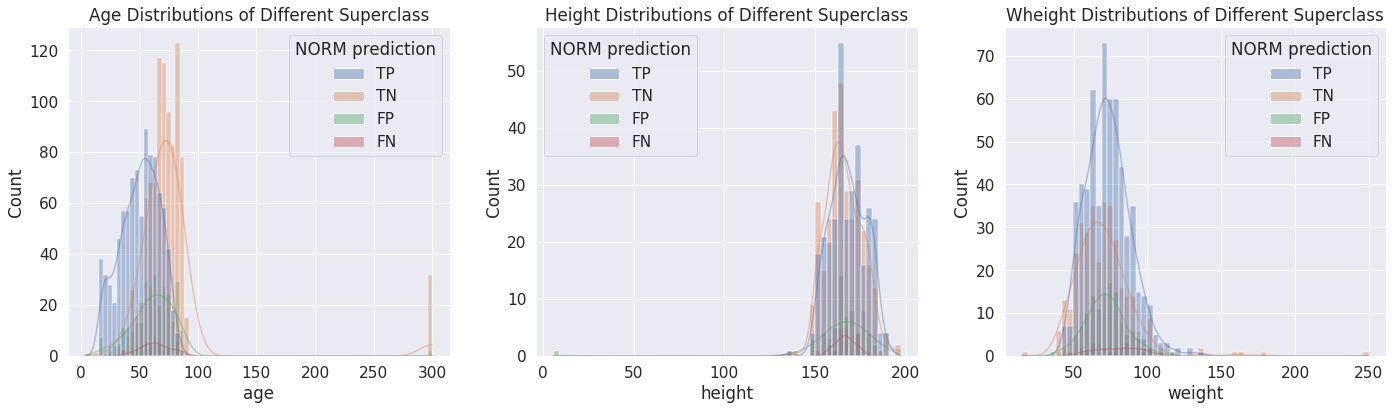


 
 
 

Showing distribution of age, height and weight for the different predictions on the MI label


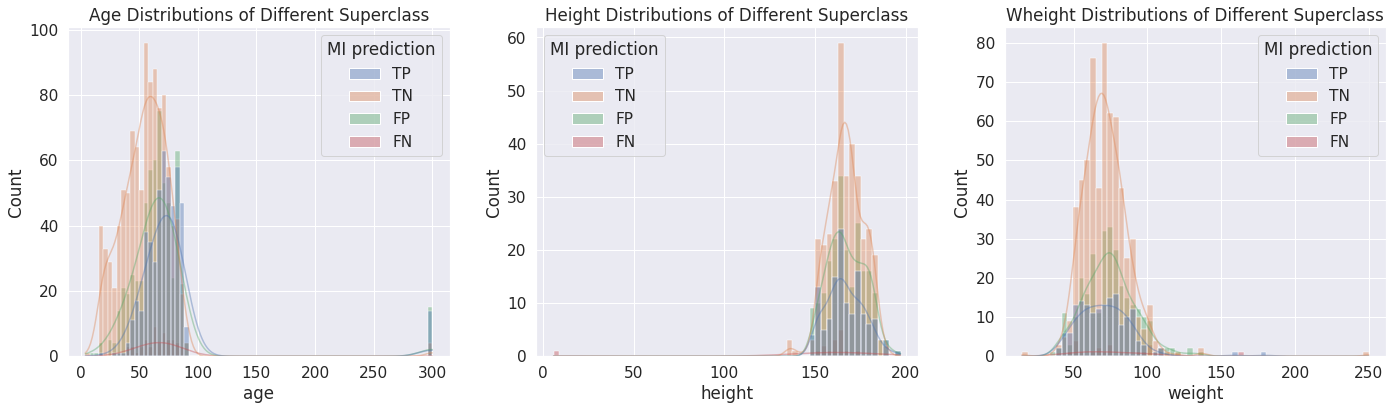


 
 
 

Showing distribution of age, height and weight for the different predictions on the STTC label


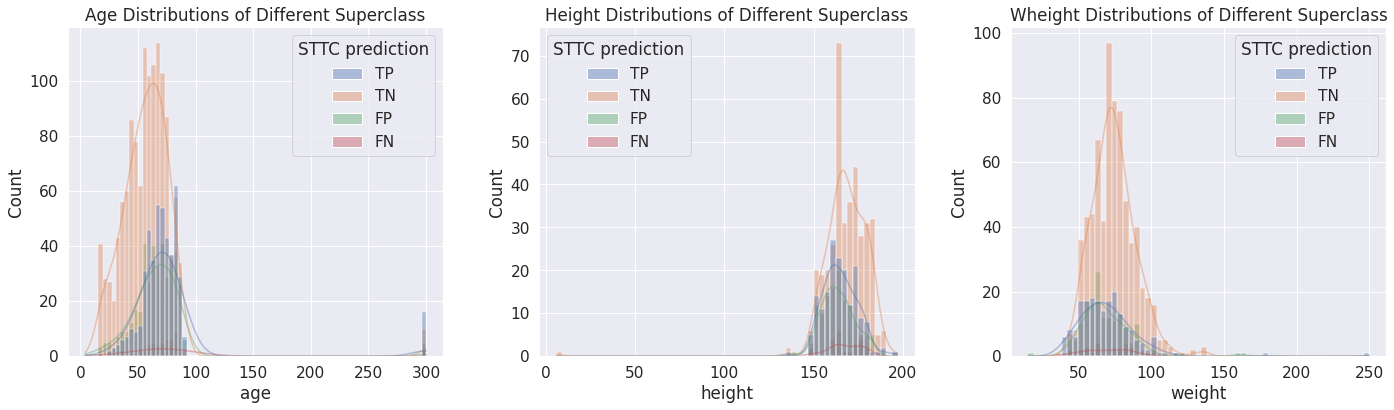


 
 
 

Showing distribution of age, height and weight for the different predictions on the CD label


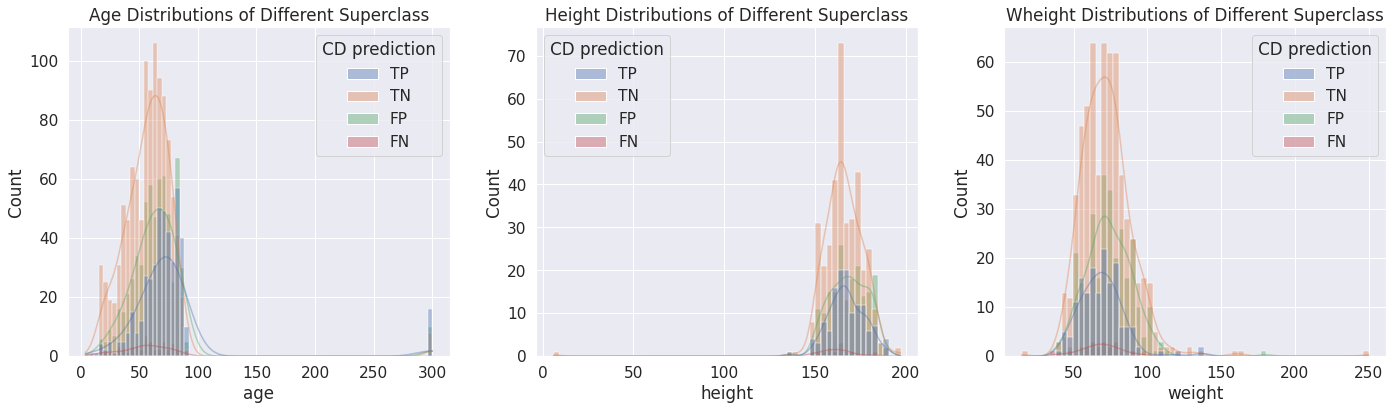


 
 
 

Showing distribution of age, height and weight for the different predictions on the HYP label


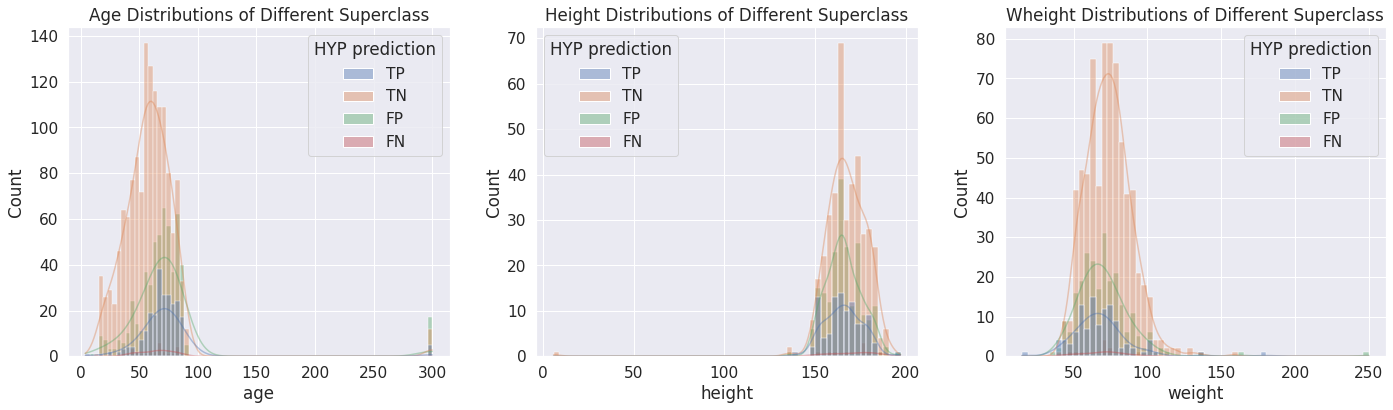

In [18]:
import warnings
warnings.filterwarnings("ignore")

def get_tp_tn_fp_fn_idx(Y_pred, Y_true, label_idx):

   Y_test = Y[Y["strat_fold"]==10] # Dataframe corresponding to the test fold

   n_rows = len(Y_test.index)

   dict_names = {0 : "NORM", 1 : "MI", 2: "STTC", 3 : "CD", 4 : "HYP"}

   for key, val in dict_names.items():
      new_column = np.zeros((n_rows,))

      y_pred = Y_pred[:,key]
      y_true = Y_true[:,key]

      pred_pos = y_pred==1.0
      pred_neg = y_pred==0.0

      true_pos = y_true==1.0
      true_neg = y_true==0.0

      TP = np.where(np.logical_and(pred_pos, true_pos))
      TN = np.where(np.logical_and(pred_neg, true_neg))
      FP = np.where(np.logical_and(pred_pos, true_neg))
      FN = np.where(np.logical_and(pred_neg, true_pos))

      new_column[TP] = 0
      new_column[TN] = 1
      new_column[FP] = 2
      new_column[FN] = 3

      Y_test[f"{val} prediction"] = new_column
      Y_test[f"{val} prediction"] = Y_test[f"{val} prediction"].map({0: "TP", 1:"TN", 2:"FP", 3:"FN"})

      print(f"Showing distribution of age, height and weight for the different predictions on the {val} label")

      fig, axs = plt.subplots(1,3, figsize=(20,6))

      axs[0].set_title('Age Distributions of Different Superclass')
      c_list = ["r", "g", "b", "y", "pink"]
      sns.histplot(data=Y_test[["age", f"{val} prediction"]], x="age", ax=axs[0], kde=True, color=c_list[idx], alpha=0.4, line_kws={"alpha": 0.4}, hue=f"{val} prediction",
                   hue_order=["TP", "TN", "FP", "FN"])
      axs[1].set_title('Height Distributions of Different Superclass')
      c_list = ["r", "g", "b", "y", "pink"]
      sns.histplot(data=Y_test[["height", f"{val} prediction"]], x="height", ax=axs[1], kde=True, color=c_list[idx], alpha=0.4, line_kws={"alpha": 0.4}, hue=f"{val} prediction",
                   hue_order=["TP", "TN", "FP", "FN"])

      axs[2].set_title('Wheight Distributions of Different Superclass')
      c_list = ["r", "g", "b", "y", "pink"]
      sns.histplot(data=Y_test[["weight", f"{val} prediction"]], x="weight", ax=axs[2], kde=True, color=c_list[idx], alpha=0.4, line_kws={"alpha": 0.4}, hue=f"{val} prediction",
                   hue_order=["TP", "TN", "FP", "FN"])
      plt.tight_layout()
      plt.show()

      print("\n \n \n \n")


   return Y_test

Y_test = get_tp_tn_fp_fn_idx(y_preds_discrete, y_trues, 0)